In [6]:
!pip install tensorflow

In [2]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import soundfile as sf
import os
import glob
import tqdm
import json
import librosa
from librosa import display
from pathlib import Path
import IPython.display as pd
import matplotlib.pyplot as plt

In [53]:
!pip install madmom

  Created wheel for madmom: filename=madmom-0.16.1-cp38-cp38-win_amd64.whl size=20012588 sha256=cd257c14a23d492b44a4fa7a805f612f6aa89f6d5cad6fb49e5799b19fea2688
  Stored in directory: c:\users\oezde\appdata\local\pip\cache\wheels\a2\fc\0f\2d5569ea771ee70a9bf321a72744b4507eb85ff540d82b54eb
Successfully built madmom


In [18]:
from scipy.ndimage.filters import maximum_filter1d
from copy import deepcopy
import numpy as np
import joblib
import os
import csv
from madmom.io import midi
import warnings



In [5]:
folders = glob.glob('E:/Deep Learning/e-gmd-v1.0.0_w/*/*/')
folders


['E:/Deep Learning/e-gmd-v1.0.0_w\\drummer1\\eval_session\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer1\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer1\\session2\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer1\\session3\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer10\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer3\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer3\\session2\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer4\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer5\\eval_session\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer5\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer5\\session2\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer6\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer6\\session2\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer6\\session3\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer7\\eval_session\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer7\\session1\\',
 'E:/Deep Learning/e-gmd-v1.0.0_w\\drummer7\\session2\\',
 

fps: 45537


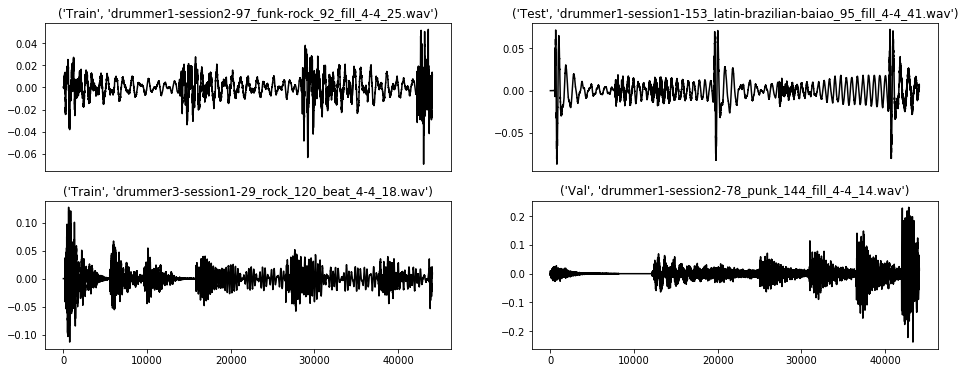

In [8]:
# get all wav files
fps = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/**/*.wav', recursive=True)
print(f"fps: {len(fps)}")
fps_random = []
np.random.seed(9)

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, duration=1,sr=None)
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

In [11]:
# 7 hits from the original paper
classes = ['KD','SD','TT','HH','CY','RD','BE']

# best-practice: write down your preprocessing config in a dictonary
config = {'sr': 16000, 
          'audio_length': 1,  # in seconds
          'mono': True,
          'n_mels': 250,  # number bins / vertical resolution? 250
          'n_fft': 2048,  # 2048 samples for fft
          'hop_length': 441, # shift to the right / frames with 10ms width
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'pad_mode': 'reflect',
          'power': 2.0,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config 
with open('/Volumes/Ext_SSD/e-gmd-v1.0.0/e-gmd.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

{
    "sr": 16000,
    "audio_length": 1,
    "mono": true,
    "n_mels": 250,
    "n_fft": 2048,
    "hop_length": 441,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "pad_mode": "reflect",
    "power": 2.0,
    "classes": [
        "KD",
        "SD",
        "TT",
        "HH",
        "CY",
        "RD",
        "BE"
    ],
    "n_frames": 37,
    "input_shape": [
        250,
        37,
        1
    ]
}


44100
44100
44100
44100
Melspec shape: (250, 101)
Stft shape: (1025, 101)
Total data points in mel-spectrogram: 25250
Total data points in stft-spectrogram: 103525
-> Data Reduction by factor: 4.1



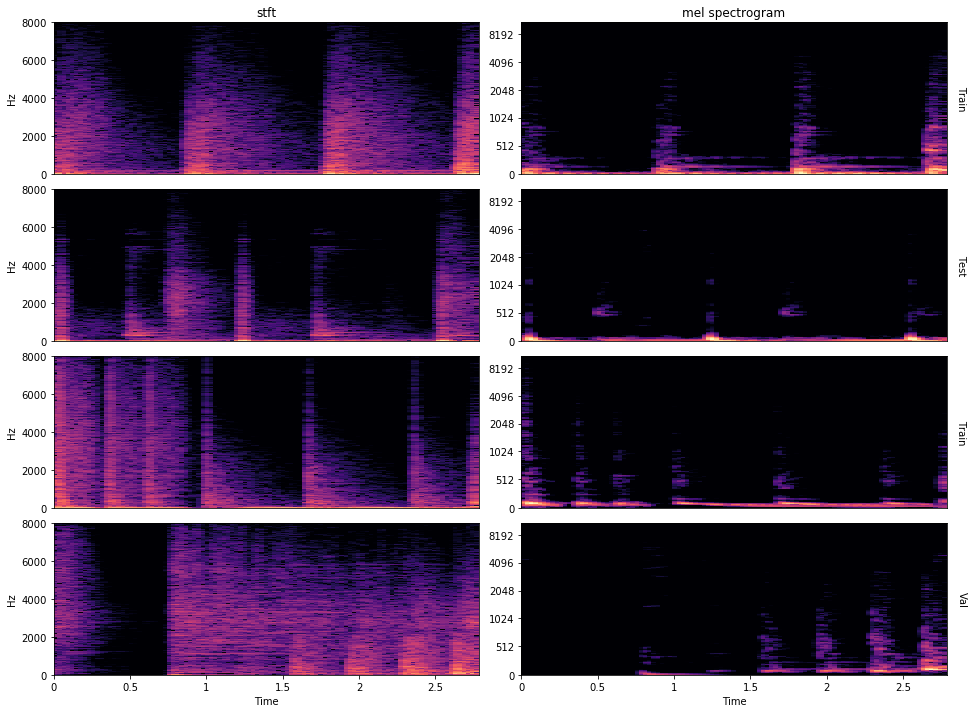

In [12]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, duration=1,sr=None)
    print(sr)
    # calculate stft
    stft = librosa.stft(audio, n_fft=config['n_fft'], hop_length=config['hop_length'], win_length=config['win_length'])
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=config['n_fft'], hop_length=config['hop_length'], win_length=config['win_length'], n_mels=config['n_mels'], fmax=int(config['sr']/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # calculate magnitude and scale to dB
    magspec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # plot with librosa
    librosa.display.specshow(magspec, x_axis='time', y_axis='linear', sr=config['sr'], hop_length=config['hop_length'], ax=ax[i][0])
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=config['sr'], hop_length=config['hop_length'], ax=ax[i][1])
    
    # adjustments
    # ax[i][1].set_yticks([])
    ax[i][1].set_ylabel(Path(fp_random).parts[-2], rotation=270, labelpad=20)
    ax[i][1].yaxis.set_label_position("right")
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([])
        ax[i][1].set_xticks([])
        ax[i][0].set_xlabel('')
        ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('stft')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Melspec shape: %s' % (str(melspec.shape)))
print('Stft shape: %s' % (str(stft.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in stft-spectrogram: {stft.shape[0]*stft.shape[1]}')
print(f'-> Data Reduction by factor: {(stft.shape[0]*stft.shape[1]) / (melspec.shape[0]*melspec.shape[1])}')
print()

In [9]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)

In [20]:
path_midi = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/**/*.midi', recursive=True)[1]
print(path_midi)


/Volumes/Ext_SSD/e-gmd-v1.0.0/Test/drummer1-eval_session-10_soul-groove10_102_beat_4-4_10.midi


In [21]:
pattern = midi.MIDIFile(path_midi)

print(type(pattern.notes))
pattern.notes[1]

<class 'numpy.ndarray'>


array([0.00000000e+00, 3.60000000e+01, 8.70097604e-02, 1.27000000e+02,
       9.00000000e+00])

In [24]:
#drum mapping dictionary
drum_mapping={
          36: 0, #kick
          38: 1, #snare head
          40: 2, #snare rim
          37: 3, #snare x-stick
          48: 4, #tom1
          50: 5, #tom1_rim
          45: 6, #tom2
          47: 7, #tom2_rim
          43: 8, #tom3_head
          58: 9, #tom3_rim
          46: 10,#hhopen_bow
          26: 11,#hhopen_edge
          42: 12,#hhclosed_bow
          
          22: 13,#hhclosed_edge
          44: 14,#hhpedal
          49: 15,#crash1_bow
          55: 16,#crash1_edge
          57: 17,#crash2_bow
          52: 18,#crash2_edge
          51: 19,#ride_bow          
          59: 20,#ride_edge
          53: 21,#ride_bell
          
          39: 22,#clap
          54: 23,#tambourine
          56: 24,#cowbell
          70: 25,#maracas
          64: 26,#low_conga
          75: 27 #claves
         }

# save config 
with open('/Volumes/Ext_SSD/e-gmd-v1.0.0/e-gmd.json', 'w+') as fp:
    json.dump(drum_mapping, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(drum_mapping, indent=4))

print(type(drum_mapping[36]))

{
    "36": 0,
    "38": 1,
    "40": 2,
    "37": 3,
    "48": 4,
    "50": 5,
    "45": 6,
    "47": 7,
    "43": 8,
    "58": 9,
    "46": 10,
    "26": 11,
    "42": 12,
    "22": 13,
    "44": 14,
    "49": 15,
    "55": 16,
    "57": 17,
    "52": 18,
    "51": 19,
    "59": 20,
    "53": 21,
    "39": 22,
    "54": 23,
    "56": 24,
    "70": 25,
    "64": 26,
    "75": 27
}
<class 'int'>


In [25]:
#get ground thruth

def get_y_from_file(midifile, n_frames):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pattern = midi.MIDIFile(midifile)
        dt = float(config['hop_length']) / float(config['sr'])
        label=5
        y_onsets = np.zeros((n_frames, 27), dtype=np.uint8) #28 instruments deswegen 28-1 
        
        for note in pattern.notes:
            instrument=int(note[1])  #1st value in array is for instrument type
            label=drum_mapping[instrument]

            note_start = int(np.round(note[0] / dt)) # 0. value in array is the onset
            #note_end = int(np.round(note[0] + note[2] / dt)) # 2. value in array the duration
            #print(instrument)
            #print(note_start)
            
            
            if note_start < n_frames:
                y_onsets[note_start, label] = 1
            
            else:
                print('Offset > n_frames reached')
                break
            


        return y_onsets

In [26]:
ground_truth=get_y_from_file(path_midi,config['n_frames'])


Offset > n_frames reached


In [27]:
ground_truth


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

In [28]:
#print onset i[0], label i[1] or duration [2] here -
pattern = midi.MIDIFile(path_midi)

for i in pattern.notes:
    if (i[0] >= config['audio_length']):
        break
    
    print(i[1])
    print(i[0])

22.0
0.0
36.0
0.0
42.0
0.2879900520833333
40.0
0.5649506979166665
42.0
0.5735291249999999
38.0
0.7034310208333332
42.0
0.8909309270833332


In [29]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)


def load_and_preprocess_data(file_path):
    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    
    
    # load audio data 
    y, _ = librosa.core.load(file_path, sr=config['sr'], mono=config['mono'], offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')

    # calculate stft from audio data
    stft = librosa.core.stft(y, n_fft=config['n_fft'], hop_length=config['hop_length'], 
                             win_length=config['win_length'], window=config['window'], 
                             center=config['center'], dtype=np.complex64, pad_mode=config['pad_mode'])

    # filter stft with mel-filter
    mel_spec = mel_filter.dot(np.abs(stft).astype(np.float32) ** config['power'])
    
    # add channel dimension for conv layer  compatibility
    mel_spec = np.expand_dims(mel_spec, axis=-1)
    
    # get ground truth from file_path string
    ground_truth = get_y_from_file(path_midi,config['n_frames'])
    
    return mel_spec, ground_truth


# there is a TF bug where we get an error if the size of the tensor from a py.function is not set manualy
# when called from a map()-function.
def preprocessing_wrapper(file_path):
    mel_spec, ground_truth = tf.py_function(load_and_preprocess_data, [file_path], [tf.float32, tf.uint8])
    
    mel_spec.set_shape([config['n_mels'], config['n_frames'], 1])
    ground_truth.set_shape([len(config['classes'])])
    return mel_spec, ground_truth

## Onset Model

In [ ]:
# create model architecture
model_onset = tf.keras.Sequential()
model_onset.add(tf.keras.Input(shape=config['input_shape']))
model_onset.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu"))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu"))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_onset.add(tf.keras.layers.GaussianDropout(0.75))
model_onset.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_onset.add(tf.keras.layers.GaussianDropout(0.75))
model_onset.add(tf.keras.layers.Dense(256, activation="relu"))
model_onset.add(tf.keras.layers.GaussianDropout(0.5))
model_onset.add(Bidirectional(LSTM(64),dropout=0.5))
model_onset.add(tf.keras.layers.Dense(88, activation="sigmoid"))
model_onset.summary()

## Compile and Fit

In [ ]:
# compile model
model_onset.compile(optimizer='adam',
              loss='sigmoid_cross_entropy',
              metrics=['accuracy'])

# Number of epochs to train (change it accordingly)
n_epochs = 10  # same as in fit()?

# train model
hist = model_onset.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.2)

# fit model
model_onset.fit(train_dataset, epochs=10)

# test
model_onset.evaluate(test_dataset)

## Velocity Model

In [ ]:
# create model architecture
model_veloc = tf.keras.Sequential() # initialize model
model_veloc.add(tf.keras.Input(shape=config['input_shape']))
model_veloc.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu"))
model_veloc.add(tf.keras.layers.BatchNormalization())
model_veloc.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu"))
model_veloc.add(tf.keras.layers.BatchNormalization())
model_veloc.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_veloc.add(tf.keras.layers.GaussianDropout(0.75))
model_veloc.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"))
model_veloc.add(tf.keras.layers.BatchNormalization())
model_veloc.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_veloc.add(tf.keras.layers.GaussianDropout(0.75))
model_veloc.add(tf.keras.layers.Dense(256, activation="relu"))
model_veloc.add(tf.keras.layers.GaussianDropout(0.5))
model_veloc.add(tf.keras.layers.Dense(88, activation="sigmoid")) 
model_veloc.summary()

## Compile and Fit

In [ ]:
# compile model
model_veloc.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

# fit model
model_veloc.fit(train_dataset, epochs=10)
model_veloc.evaluate(test_dataset)